<a href="https://colab.research.google.com/github/springboardmentor789r/AgriYield/blob/Intern_SaniyaMariyam/AgriYield_Predictor(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from google.colab import files
uploaded = files.upload()

# Load dataset
df = pd.read_excel("crop_yield_dataset.xlsx")

# Drop rows where Crop_Yield = 0
df = df[df["Crop_Yield"] != 0]

# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Drop rows with invalid dates
df = df.dropna(subset=["Date"])

# Set Date as index first
df.set_index("Date", inplace=True)

# Drop categorical (non-numeric) columns
df_numeric = df.select_dtypes(include=['number'])

# Resample to daily interval, taking mean of all numeric columns
df_daily = df_numeric.resample("D").mean()

# Drop rows that are fully NaN after resampling
df_daily = df_daily.dropna(how="all")

# Save the preprocessed dataset
output_file = "time_series_analysis_dataset.xlsx"
df_daily.to_excel(output_file)

print("Preprocessing Complete!")
print(f"Saved preprocessed dataset as: {output_file}")
print(f"New Shape: {df_daily.shape}")

# Download the file automatically
files.download(output_file)


Saving crop_yield_dataset.xlsx to crop_yield_dataset.xlsx
Preprocessing Complete!
Saved preprocessed dataset as: time_series_analysis_dataset.xlsx
New Shape: (3624, 9)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
print(df_daily.head())

             Soil_pH  Temperature   Humidity  Wind_Speed          N  \
Date                                                                  
2014-01-01  6.250000    17.832341  79.992489    7.649061  61.285714   
2014-01-02  6.928571    17.403738  79.997477    9.731096  67.285714   
2014-01-03  6.250000    17.710699  78.611669   12.161914  60.785714   
2014-01-04  7.125000    17.068594  79.349411    9.476664  69.375000   
2014-01-05  6.375000    15.439732  80.000000   10.793227  68.062500   

                    P          K  Crop_Yield  Soil_Quality  
Date                                                        
2014-01-01  50.142857  40.142857   52.962570     41.714286  
2014-01-02  54.500000  43.785714   49.481053     31.964286  
2014-01-03  49.571429  40.142857   31.582386     40.601190  
2014-01-04  56.000000  44.937500   35.247034     38.703125  
2014-01-05  54.562500  43.125000   32.578187     48.994792  


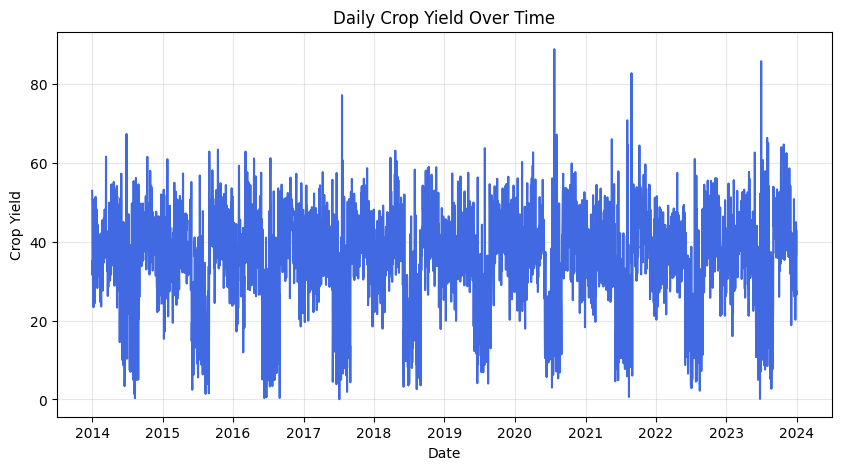


--- ADF Test ---
ADF Statistic: -7.1481
p-value: 0.0000
=> Stationary

--- KPSS Test ---
KPSS Statistic: 0.0434
p-value: 0.1000
=> Stationary


/tmp/ipython-input-3515878239.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(ts, regression="c", nlags="auto")


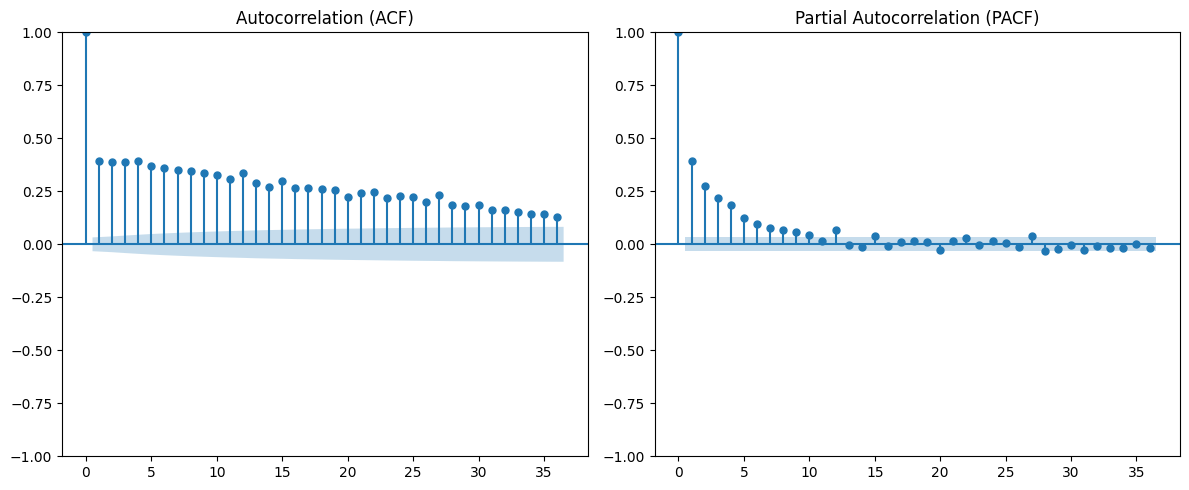

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load preprocessed dataset
df_daily = pd.read_excel("time_series_analysis_dataset.xlsx", index_col="Date", parse_dates=True)

# Select target column for time series analysis
ts = df_daily["Crop_Yield"].dropna()

# Plot time series
plt.figure(figsize=(10,5))
plt.plot(ts, color='royalblue')
plt.title("Daily Crop Yield Over Time")
plt.xlabel("Date")
plt.ylabel("Crop Yield")
plt.grid(alpha=0.3)
plt.show()

# Augmented Dickey-Fuller Test (ADF)
print("\n--- ADF Test ---")
adf_result = adfuller(ts)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
if adf_result[1] <= 0.05:
    print("=> Stationary")
else:
    print("=> Not Stationary")

# KPSS Test
print("\n--- KPSS Test ---")
kpss_result = kpss(ts, regression="c", nlags="auto")
print(f"KPSS Statistic: {kpss_result[0]:.4f}")
print(f"p-value: {kpss_result[1]:.4f}")
if kpss_result[1] > 0.05:
    print("=> Stationary")
else:
    print("=> Not Stationary")

# Autocorrelation and Partial Autocorrelation
fig, axes = plt.subplots(1, 2, figsize=(12,5))
plot_acf(ts, ax=axes[0])
plot_pacf(ts, ax=axes[1])
axes[0].set_title("Autocorrelation (ACF)")
axes[1].set_title("Partial Autocorrelation (PACF)")
plt.tight_layout()
plt.show()

In [5]:
pip uninstall prophet fbprophet -y


Found existing installation: prophet 1.1.7
Uninstalling prophet-1.1.7:
  Successfully uninstalled prophet-1.1.7


In [6]:
pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 52.1 MB/s eta 0:00:00


In [7]:
pip install prophet --quiet

In [8]:
from prophet import Prophet
print("Prophet installed correctly!")

Prophet installed correctly!


Numeric regressors: ['Soil_pH', 'Temperature', 'Humidity', 'Wind_Speed', 'N', 'P', 'K', 'Soil_Quality']
Categorical regressors: []
Final exogenous features used: ['Soil_pH', 'Temperature', 'Humidity', 'Wind_Speed', 'N', 'P', 'K', 'Soil_Quality']

Training Prophet model with exogenous variables...

=== Prophet (with Regressors) Evaluation ===
MAE  : 4.7650
RMSE : 6.2270
R²   : 0.7378



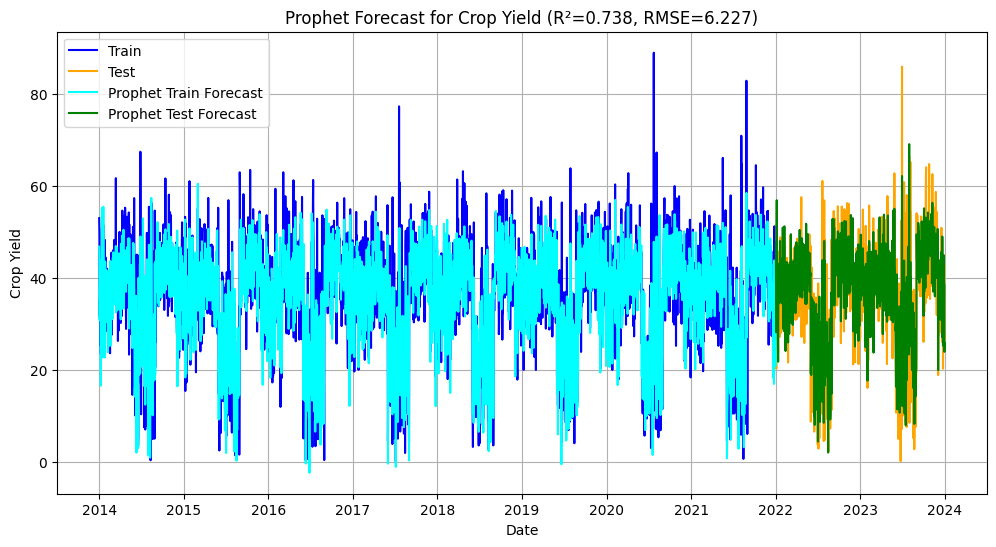

In [9]:
# Prophet Forecasting
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Prepare the dataset
df_exog = df_daily.copy().reset_index()

# Rename required columns
df_exog.rename(columns={"Date": "ds", "Crop_Yield": "y"}, inplace=True)

# Drop missing target values
df_exog = df_exog.dropna(subset=["y"])

# Identify regressors
exogenous_features = [col for col in df_exog.columns if col not in ["ds", "y"]]

# Separate categorical and numeric columns
cat_cols = df_exog[exogenous_features].select_dtypes(include=["object"]).columns.tolist()
num_cols = df_exog[exogenous_features].select_dtypes(include=["number"]).columns.tolist()

print(f"Numeric regressors: {num_cols}")
print(f"Categorical regressors: {cat_cols}")

# Split into train/test
train_size = int(len(df_exog) * 0.8)
train_df = df_exog.iloc[:train_size].copy()
test_df = df_exog.iloc[train_size:].copy()

# Encode categorical features (fit on train only)
for col in cat_cols:
    le = LabelEncoder()
    le.fit(train_df[col].astype(str))
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))

# Update the list of regressors
exogenous_features = num_cols + cat_cols
print(f"Final exogenous features used: {exogenous_features}\n")

# Define & Train Prophet
model = Prophet(
    daily_seasonality=True,
    yearly_seasonality=True,
    weekly_seasonality=True,
)

# Add exogenous regressors
for reg in exogenous_features:
    model.add_regressor(reg)

print("Training Prophet model with exogenous variables...")
model.fit(train_df)

# Forecasting (Train + Test)
future = model.make_future_dataframe(periods=len(test_df))

# Add regressors for both train and test
future_exog = pd.concat([train_df[exogenous_features], test_df[exogenous_features]], axis=0).reset_index(drop=True)
future[exogenous_features] = future_exog

# Predict
forecast = model.predict(future)

# Extract train and test forecasts separately
forecast_train = forecast.iloc[:len(train_df)]
forecast_test = forecast.iloc[-len(test_df):]

# Evaluate on Test Data
y_true_test = test_df["y"].values
y_pred_test = forecast_test["yhat"].values

mae = mean_absolute_error(y_true_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
r2 = r2_score(y_true_test, y_pred_test)

print("\n=== Prophet (with Regressors) Evaluation ===")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}\n")

# Plot Results
plt.figure(figsize=(12,6))
plt.plot(train_df["ds"], train_df["y"], label="Train", color='blue')
plt.plot(test_df["ds"], test_df["y"], label="Test", color='orange')

# Plot predictions for train + test
plt.plot(train_df["ds"], forecast_train["yhat"], label="Prophet Train Forecast", color='cyan')
plt.plot(test_df["ds"], forecast_test["yhat"], label="Prophet Test Forecast", color='green')

plt.title(f"Prophet Forecast for Crop Yield (R²={r2:.3f}, RMSE={rmse:.3f})")
plt.xlabel("Date")
plt.ylabel("Crop Yield")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
import pickle
from google.colab import files

# Save the trained Prophet model
with open("prophet_crop_yield_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("Prophet model exported successfully as prophet_crop_yield_model.pkl")

# Download the file to your system
files.download("prophet_crop_yield_model.pkl")


Prophet model exported successfully as prophet_crop_yield_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>